# Binary Prediction of Poisonous Mushrooms

### Artificial Intelligence 2nd Project

The aim of this project is to implement and evaluate machine learning models for predicting whether a mushroom is **poisonous** or **edible** based on its physical characteristics. As such, this is a binary classification problem, where the target variable is the venomosity of the mushroom.

To achieve our goal, we will follow the standard machine learning pipeline, which consists of analyzing the data, preprocessing it to ensure higher accuracy, and, finally, training and comparing the models.

The following work was done by:

| Name                 | Email                          |
|----------------------|--------------------------------|
| Bruno Drumond        | up201202666@edu.fe.up.pt       |
| Tomás Sucena Lópes   | up202108701@edu.fe.up.pt       |

1. Coding Environment  
    - Importing the Libraries  
    - Loading the Dataset  
2. Initial Data Exploration  
3. Data Cleaning  
    - Removing Duplicates  
    - Filling in Missing Values  
4. Data Analysis  
    - Detecting Outliers  
    - Exploring Correlations between Features  
    - Feature Selection  
    - Balancing the Dataset  
5. Training the Models  
    - Encoding Qualitative Data  
    - Model Assessment  
        - Decision Trees  
        - Random Forests  
        - Categorical Naive Bayes  
        - Logistic Regression  
        - K-Nearest Neighbors  
        - Support Vector Machines  
        - Extreme Gradient Boosting  
6. Conclusion
    - Results and Analysis
    - Future Works

## Coding Environment

### Importing the libraries

Due to its extensive machine learning ecosystem, we have opted to use [Python](https://www.python.org/) for this project. As such, before proceeding, it is imperative to prepare our coding environment by importing the libraries we will be working with, namely:

* **[Pandas](https://pandas.pydata.org/)** - For data manipulation and preprocessing.
* **[Scikit-learn](https://scikit-learn.org/stable/)** - For implementing machine learning models and evaluation metrics.
* **[Matplotlib](https://matplotlib.org/)** - For creating graphs, tables, and numerous other data visualization methods.
* **[NumPy](https://numpy.org/)** - For numerical operations, especially working with arrays and performing mathematical computations efficiently.
* **[Seaborn](https://seaborn.pydata.org/)** - For advanced data visualization built on top of Matplotlib, offering enhanced plots and built-in themes.
* **[SciPy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html)** - For performing statistical tests, distributions, and probability functions for data analysis.

In [84]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

### Loading the Dataset

Next, we must load the data itself, which is stored in a compressed CSV file. However, there is no need to manually uncompress it, as Pandas handles that automatically.

In [85]:
df = pd.read_csv('data/train.zip')

## Initial Data Exploration

It is evident that having a solid understanding of the data is paramount to training accurate models. Therefore, having finished the setup, the first step is to **explore** the dataset to uncover its characteristics. To start, below is a small excerpt from our dataset:


In [86]:
print('First rows from our dataset:')
df.head()

First rows from our dataset:


,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


Before proceeding, it is clear that the `id` column offers no significant information, as it simply indicates the index of the corresponding row. As such, we can safely drop it from the dataset.

In [87]:
df.drop('id', axis=1, inplace=True)

With that out of the way, we should analyze the data types of the remaining columns to get a better picture of the complete dataset.

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 499.4+ MB


As such, our dataset contains 21 columns and over 3 million rows. Regarding the columns, only three contain **quantitative** data, whereas the remaining 18 pertain to **qualitative** data. To facilitate further analysis, we will categorize and extract the columns into distinct variables based on their data type.

In [89]:
target_column = 'class'

# compute the quantitative columns
quantitative_columns = df.select_dtypes(include=['number']).columns
print('Quantitative columns: ', quantitative_columns.tolist())

# compute the qualitative columns EXCEPT the target column
qualitative_columns = df.select_dtypes(include=['object']).columns.drop(target_column)
print('\nQualitative columns: ', qualitative_columns.tolist())

Quantitative columns:  ['cap-diameter', 'stem-height', 'stem-width']

Qualitative columns:  ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']


Below is a succint description of each column:

| **Column/Feature**         | **Description**                                                                 |
|:--------------------------:|:-------------------------------------------------------------------------------:|
| `class`                    | Binary label that Indicates if the mushroom is edible or poisonous.             |
| `cap-diameter`             | Width of the cap at its widest point, in centimeters.                           |
| `cap-shape`                | General form of the cap—e.g., flat, conical, bell-shaped, or wavy.              |
| `cap-surface`              | Texture of the cap—smooth, scaly, sticky, or wrinkled.                          |
| `cap-color`                | Cap color, which may change as the mushroom matures.                            |
| `does-bruise-or-bleed`     | Indicates if the mushroom bruises or releases liquid when damaged.              |
| `gill-attachment`          | How gills connect to the stem—free, attached, or descending.                    |
| `gill-spacing`             | Distance between gills—crowded, spaced, or intermediate.                        |
| `gill-color`               | Color of the gills, which may change with age.                                  |
| `stem-height`              | Length of the stem from base to cap, in centimeters.                            |
| `stem-width`               | Thickness of the stem—narrow, medium, or thick, in centimeters.                 |
| `stem-root`                | Shape of the stem’s base—tapered, swollen, or bulbous.                          |
| `stem-surface`             | Stem texture—smooth, fibrous, scaly, or rough.                                  |
| `stem-color`               | Color of the stem, which may be uniform or variable.                            |
| `veil-type`                | Indicates a partial or universal veil.                                          |
| `veil-color`               | Color of the veil, useful for identification.                                   |
| `has-ring`                 | Indicates if a ring (annulus) is present on the stem.                           |
| `ring-type`                | Type of ring—single, double, flaring, or hanging.                               |
| `spore-print-color`        | Color of spores left on a surface; key for identification.                      |
| `habitat`                  | Environment where the mushroom grows—e.g., woods or grasslands.                 |
| `season`                   | Time of year when the mushroom is typically found.                              |


## Data Cleaning

Now that we have a basic understanding of the dataset, we must prepare it for analysis by addressing any inconsistencies, errors, or missing values that could skew our results.

### Removing Duplicates

Firstly, it is important to determine if the dataset contains **duplicate** rows, as those can be safely excluded without affecting the accuracy of our models.

In [90]:
print('The dataset contains {} duplicates.'.format(df.duplicated().sum()))

The dataset contains 0 duplicates.


As the dataset contains no duplicates, that means all rows provide relevant information, so none must be removed.

### Filling in Missing Values

Another key concern has to do with **missing values**, that is, entries that are absent from the dataset. Seeing as these provide no information, it might be sensible to either delete the rows where they appear or replace the missing entries with meaningful values.

The following highlights the amount of missing values per column:

In [91]:
missing_values_percent = 100 * df.isna().mean() # will also be used to plot the graph

print('Missing Values per column (%):')
pd.DataFrame({
    'Count': df.isna().sum(),
    'Frequency (%)': missing_values_percent,
})

Missing Values per column (%):


,Count,Frequency (%)
class,0,0.000000
cap-diameter,4,0.000128
cap-shape,40,0.001283
cap-surface,671023,21.528227
cap-color,12,0.000385
does-bruise-or-bleed,8,0.000257
gill-attachment,523936,16.809280
gill-spacing,1258435,40.373988
gill-color,57,0.001829
stem-height,0,0.000000


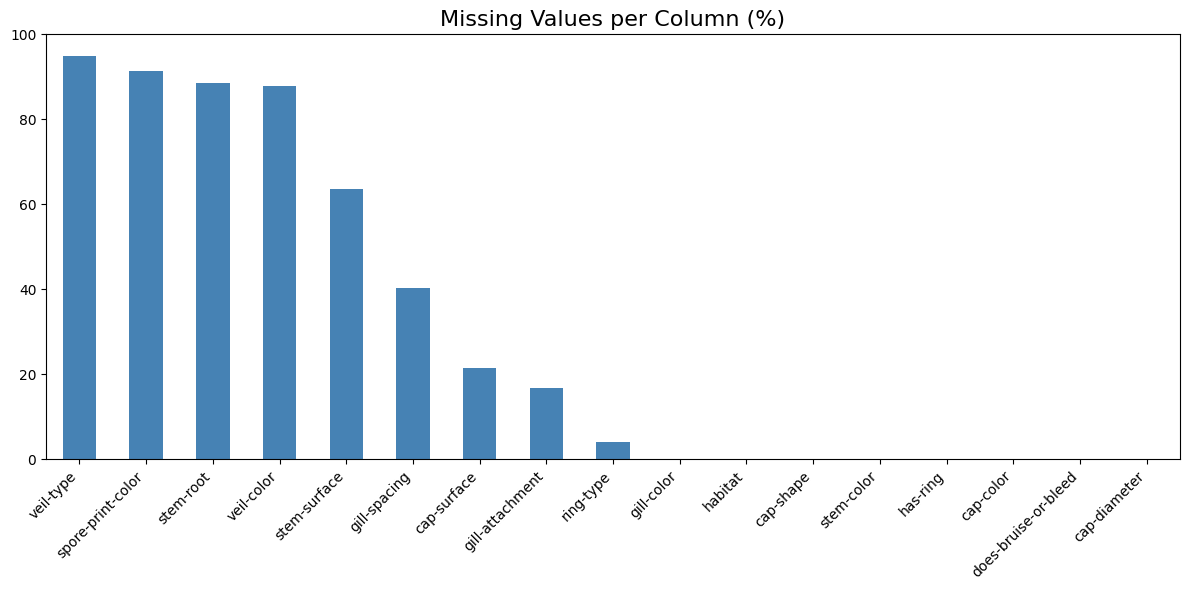

In [92]:
# plot the missing values bar graph for columns with any missing values
plt.figure(figsize=(12, 6))
plt.title('Missing Values per Column (%)', fontsize=16)
missing_values_percent[missing_values_percent > 0].sort_values(ascending=False).plot(kind='bar', color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

It is evident that the dataset has an overabundance of missing values, with some columns having over half of its entries missing. Because of this, we will opt to **fill in** the missing values, as removing the rows where they appear would result in a tremendous data loss.


#### Quantitative Data

There are several methods to fill in missing numerical data. However, the most appropriate for each column depends on the **distribution** of its values:

* If the values are symmetrically distributed, it is appropriate to fill the missing entries with the **mean** as it represents the central tendency more accurately.
* If the values are asymmetrically distributed (**skewed**), then the **median** should be used because it is less affected by outliers.

The following depicts the distribution of each quantitative column:

Skewness by column:
cap-diameter    3.972609
stem-height     1.926682
stem-width      1.235427
dtype: float64


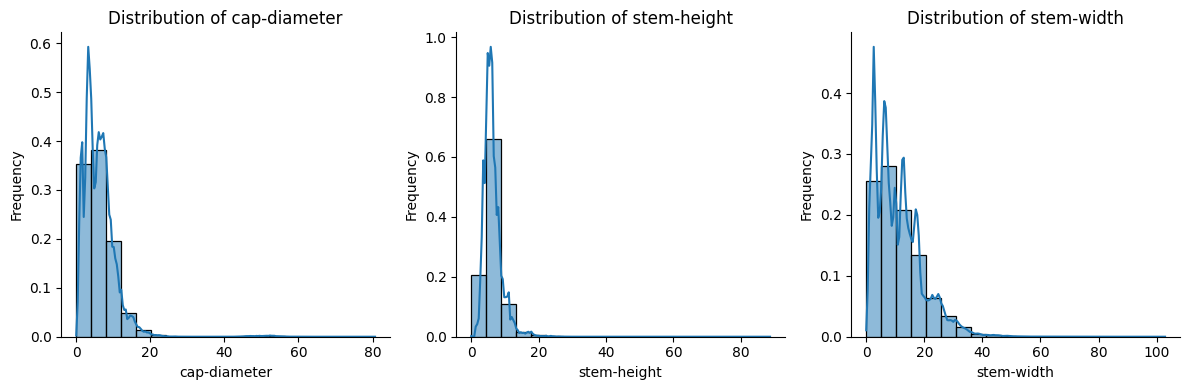

In [93]:
# compute the skewness
print('Skewness by column:')
print(df[quantitative_columns].skew())

# plot the distribution
plt.figure(figsize=(4 * len(quantitative_columns), 4))

for index, column in enumerate(quantitative_columns):
    plt.subplot(1, len(quantitative_columns), index+1)
    sns.histplot(data=df, x=column, kde=True, bins=20, stat='probability')
    plt.title(f'Distribution of {column}')
    plt.ylabel('Frequency')
    sns.despine()

plt.tight_layout() # adjust subplots to fit into figure area
plt.show()

Considering all quantitative columns are right-skewed, we must fill their missing values with the median.

In [94]:
for column in quantitative_columns:
    # compute the median of the column's values
    median = df[column].median()

    # fill the missing values with the median
    df[column] = df[column].fillna(median)

#### Qualitative Data

Handling missing values in qualitative data requires imputation strategies that consider the nature of the data, such as using the **mode**, creating a new **category**, or employing more advanced techniques based on relationships within the data.

As became apparent, there are plenty of qualitative columns where over half the entries are missing (`stem-root`, `veil-type`, `veil-color`, etc.), but there are also a few where only a small percentage is absent (`cap-shape`, `cap-color`, `does-bruise-or-bleed`, etc). So, we will take this into account when replacing the missing entries:
* If more than a predetermined percentage of data is missing, we create a new category - `Unspecified` - to group these unspecified values.
* Otherwise, we fill the missing values with the column's mode so as to preserve the distribution as much as possible.

As for the threshold, we believe 1% will help preserve the accuracy.

In [95]:
def fill_missing_qualitative_data(data: pd.Series, threshold: int) -> pd.Series:
    '''Fills missing qualitative data based on the number of missing values.'''
    missing_values = data.isna().sum() / len(data)
    mode = data.mode()

    return data.fillna('Unspecified' if missing_values > threshold or mode.empty else mode[0])


# replace the missing values with the mean
for column in qualitative_columns:
    df[column] = fill_missing_qualitative_data(df[column], 0.01)

## Data Analysis

Upon cleaning the dataset, the next step is to analyze the underlying patterns and relationships within the data.

### Detecting Outliers

Having ensured all dataset entries have a value, it is appropriate to handle any **outliers** to avoid training our models with unrepresentative data.

#### Quantitative Data

To detect outliers in quantitative data, we can start by plotting the box plot of the respective columns as this type of graph is ideal for easily identifying extremes.

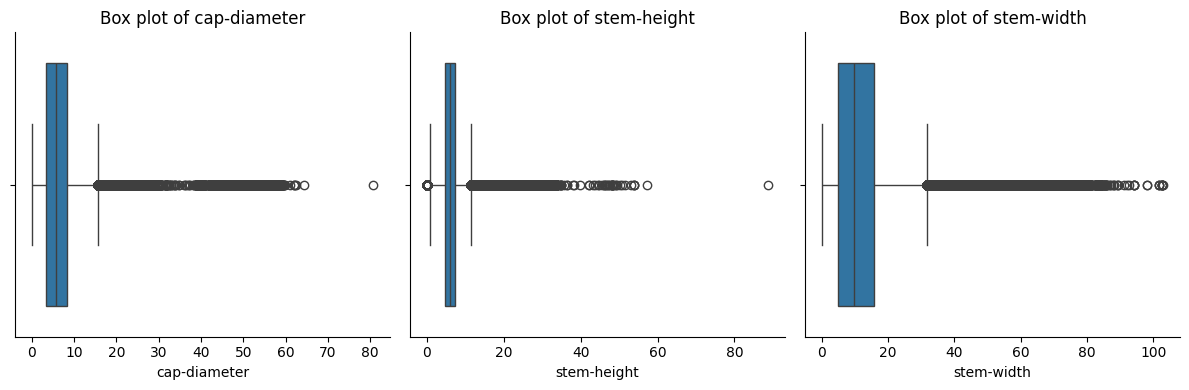

In [96]:
def display_box_plots(df, quantitative_columns):
    '''Plots the distribution of the quantitative columns.'''
    plt.figure(figsize=(4 * len(quantitative_columns), 4))

    for index, column in enumerate(quantitative_columns):
        plt.subplot(1, len(quantitative_columns), index+1)
        sns.boxplot(data=df, x=column)
        plt.title(f'Box plot of {column}')
        sns.despine()

    plt.tight_layout() # adjust subplots to fit into figure area
    plt.show()


# plot the distributions
display_box_plots(df, quantitative_columns)

From the plots above, we can conclude that there are several outliers. However, in order to decide how to deal with them, we need to understand just how many there are. 

In [97]:
def get_outliers(data: pd.Series, lower_quantile: float) -> pd.Series:
    '''Computes the outliers of a given data column.'''
    Q1 = data.quantile(lower_quantile)
    Q3 = data.quantile(1 - lower_quantile)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return data[(data < lower_bound) | (data > upper_bound)]


# calculate the percentage of outliers for each quantitative column
print('Outliers by column (%):')

for column in quantitative_columns:
    outliers = get_outliers(df[column], 0.25)
    outliers_percentage = 100 * len(outliers) / len(df[column])

    print(f'{column}\t{round(outliers_percentage, 2)}')

Outliers by column (%):
cap-diameter	2.44
stem-height	4.25
stem-width	2.13


As evidenced, with $Q_{0.25}$ and $Q_{0.75}$ as lower and upper bounds, each quantitative column contains fewer than 5% outliers. Therefore, removing the rows where they appear would not incur a severe data loss for individual columns. However, assuming the worst-case scenario of only one outlier per row, we would be losing over 8% of the dataset, which is not ideal.

One possible solution would be to reduce the threshold and obtain fewer outliers. However, considering our quantitative columns are right-skewed, we believe applying a variance-stabilizing transformation should be more fruitful, as it would not only reduce the impact of large values but also normalize the distribution of our columns. With that in mind, we will apply a **logarithmic transformation** to the quantitative columns.

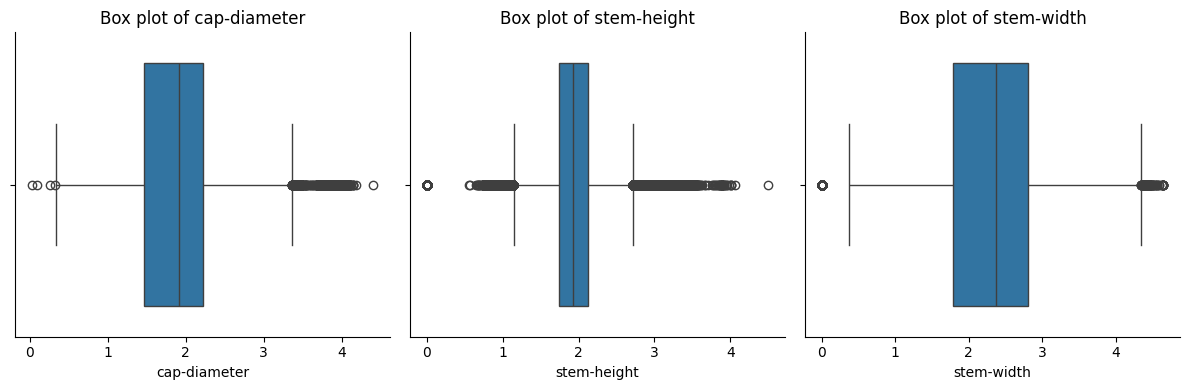

In [98]:
# apply logarithmic transformation
for column in quantitative_columns:
    df[column] = np.log1p(df[column])

# view the updated box plots
display_box_plots(df, quantitative_columns)

#### Qualitative Data

Even though outliers are commonly associated with quantitative data, they can also occur in qualitative data. In this case, the term refers to categories that are atypically infrequent i.e. that appear significantly less than the others.

To identify these values, we will compute the percentage of each category per column.

In [99]:
for column in qualitative_columns:
    # compute the frequency of each category
    freqs = pd.DataFrame({
        'Count': df[column].value_counts(),
        'Frequency (%)': df[column].value_counts(normalize=True) * 100
    })

    print(f"\nCategory Frequency in '{column}'")
    print(freqs.head(10))


Category Frequency in 'cap-shape'
             Count  Frequency (%)
cap-shape                        
x          1436066      46.072869
f           676238      21.695538
s           365146      11.714868
b           318646      10.223023
o           108835       3.491720
p           106967       3.431790
c           104520       3.353283
d               65       0.002085
e               60       0.001925
n               41       0.001315

Category Frequency in 'cap-surface'
              Count  Frequency (%)
cap-surface                       
Unspecified  671023      21.528227
t            460777      14.782969
s            384970      12.350876
y            327826      10.517542
h            284460       9.126244
g            263729       8.461137
d            206832       6.635728
k            128875       4.134657
e            119712       3.840684
i            113440       3.639461

Category Frequency in 'cap-color'
             Count  Frequency (%)
cap-color                      

As depicted, some categories appear very infrequently ($< 0.01\%$). Despite the desire to include all unique categories for greater fidelity, keeping these rare values in the dataset may introduce noise, as they are unlikely to provide meaningful patterns and can instead take focus away from the dominant trends.

An obvious solution to this problem would be to remove the rows containing these categories, which would naturally result in data loss. However, we can take advantage of the fact that we have a category for missing values - `Unspecified` - and use it to encapsulate these atypical categories, thus achieving the desired effect while preserving all rows.

In [100]:
def replace_infrequent_qualitative_data(data: pd.Series, freq_threshold: float)-> pd.Series:
    '''Replaces rare categorical values with 'Unspecified'.'''
    # compute the frequency of each category
    infrequent = data.value_counts(normalize=True)[lambda x : x * 100 < freq_threshold].index

    # replace the infrequent values
    return data.apply(lambda x: 'Unspecified' if x in infrequent else x)


# count the number of unique categories per column
before_unique_categories = df[qualitative_columns].nunique()

# replace the infrequent values in each column
for column in qualitative_columns:
    df[column] = replace_infrequent_qualitative_data(df[column], 0.01)

# compare the number of unique categories before and after processing
print('Unique Categories per column:')
pd.DataFrame({
    'Before': before_unique_categories,
    'After': df[qualitative_columns].nunique()
})

Unique Categories per column:


,Before,After
cap-shape,74,8
cap-surface,84,12
cap-color,78,13
does-bruise-or-bleed,26,3
gill-attachment,79,8
gill-spacing,49,4
gill-color,63,13
stem-root,39,6
stem-surface,61,9
stem-color,59,14


### Exploring Correlations between Features

Next, we will identify possible relationships between features by computing their correlations with each other and with the target variable. This analysis will deepen our understanding of the dataset and may also help us eliminate highly collinear features, reducing redundancy and improving model performance.

#### Quantitative vs Quantitative

To examine the strength between pairs of quantitative features, we will compute the **Pearson correlation coefficient**, which is a statistical measure that quantifies how two variables move together. It ranges from $-1$ (perfect negative correlation) to $1$ (perfect positive correlation). The results are as follows:

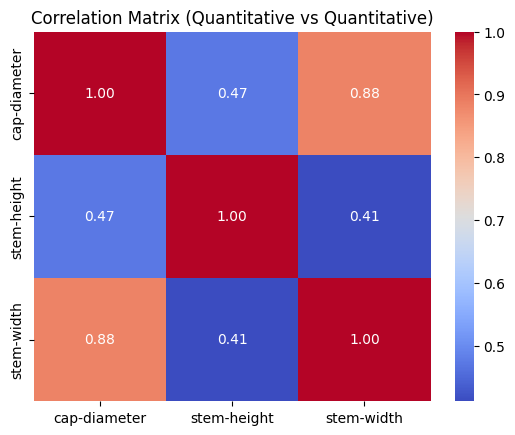

In [101]:
sns.heatmap(df[quantitative_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Quantitative vs Quantitative)')
plt.show()

As illustrated, the maximum correlation between quantitative variables pertains to `cap-diameter` and `stem-width` and is $0.88$. So, if the two are similarly related to the target variable, it might be wise to merge them.

#### Quantitative vs Target

Next, we will determine how each quantitative variable relates to the target variable. To that end, we will use the **Point-Biserial Correlation Coefficient**, which is a particular case of Pearson's correlation coefficient designed for comparing continuous variables with a binary variable. Similarly to Pearson's, the coefficient varies from $-1$ to $1$.

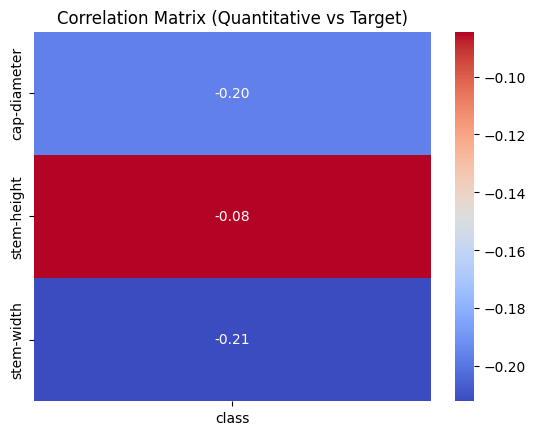

In [102]:
# encode the target variable
encoded_target = df[target_column].map({ 'e': 0, 'p': 1})

# compute the correlations
correlations = {}

for column in quantitative_columns:
    corr_coeff, _ = stats.pointbiserialr(df[column], encoded_target)
    correlations[column] = [corr_coeff] # store as a list to create a DataFrame row

# convert the correlations to a DataFrame
correlation_df = pd.DataFrame(correlations, index=['class']).T

# plot the correlation matrix
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Quantitative vs Target)')
plt.show()

As denoted, all quantitative features are weakly correlated with the target variable. Nevertheless, both `cap-diameter` and `stem-width` are identically related to the target, which, adding to the fact they are strongly correlated with each other, further corroborates that we should join them.

#### Qualitative vs Qualitative

The following step consists of computing the correlation between the many qualitative features of our dataset. To do that, we will use **Cramer's V**, a measure of association between two categorical values. It ranges from 0 to 1, where 0 indicates no association and 1 denotes perfect association.

Given this statistic is not natively implemented in any of the libraries we imported, we must first define a function for computing it.

In [103]:
def cramers_v(column_1, column_2):
    '''
    Calculate Cramer's V statistic for categorical-categorical association.
    Uses correction from Bergsma and Wicher, Journal of the Korean Statistical Society 42 (2013): 323-328
    '''
    confusion_matrix = pd.crosstab(column_1, column_2)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    # apply corrections for small sample sizes or small number of categories
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)

    # handle cases where min(kcorr-1, rcorr-1) might be zero or negative
    denominator = min((kcorr - 1), (rcorr - 1))

    return np.sqrt(phi2corr / denominator) if denominator != 0 else 0.0

We can now use the function to compute Crammer's V for each pair of qualitative features and then plot the correlation matrix.

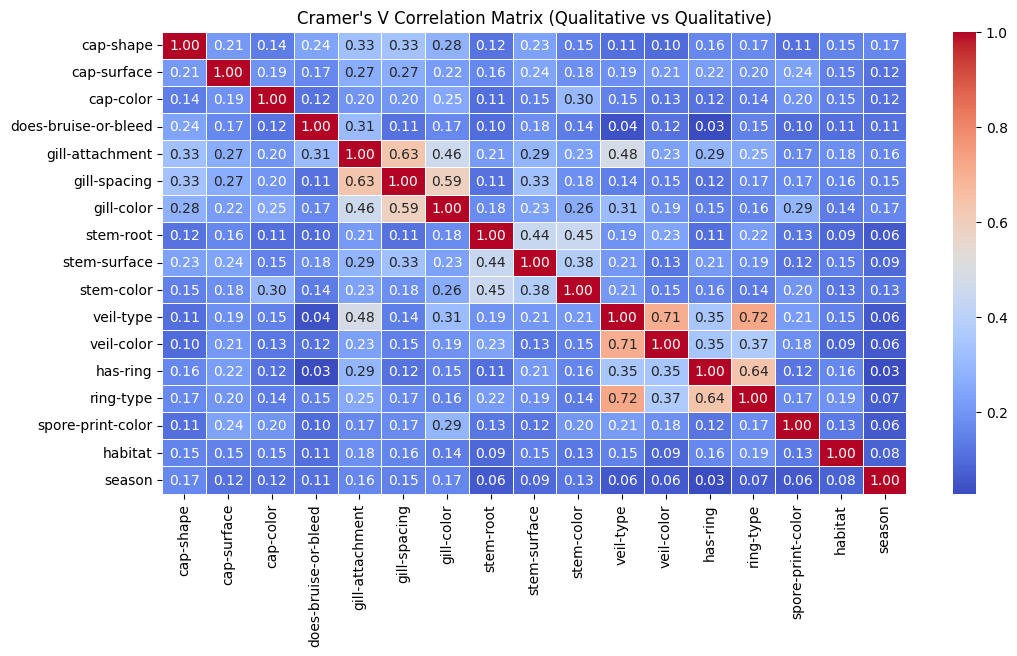

In [104]:
# initialize an empty DataFrame for the Cramer's V matrix
cramers_v_matrix = pd.DataFrame(index=qualitative_columns, columns=qualitative_columns, dtype=float)

# calculate Cramer's V for all pairs of categorical variables
for column_1 in qualitative_columns:
    for column_2 in qualitative_columns:
        if column_1 == column_2:
            cramers_v_matrix.loc[column_1, column_2] = 1.0  # a variable is perfectly correlated with itself
        else:
            v_score = cramers_v(df[column_1], df[column_2])
            cramers_v_matrix.loc[column_1, column_2] = v_score
            cramers_v_matrix.loc[column_2, column_1] = v_score # matrix is symmetrical

# plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title("Cramer's V Correlation Matrix (Qualitative vs Qualitative)")
plt.show()

As evidenced, the maximum Cramer's V value for any two pairs of features is $0.72$, which suggests none are strongly correlated with each other.

#### Qualitative vs Target

Finally, we will compare how each qualitative feature correlates with the target by reapplying **Crammer's V**.

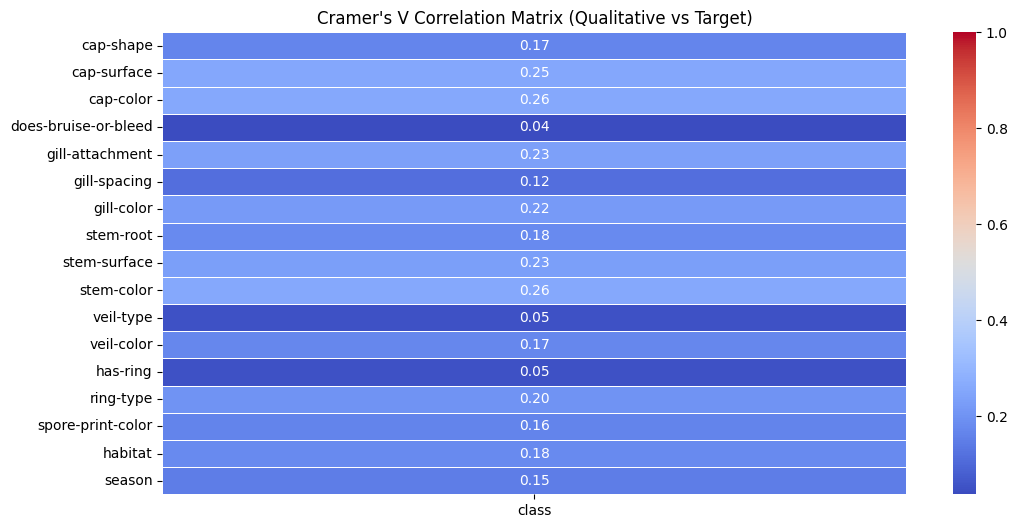

In [105]:
# initialize an empty DataFrame for the Cramer's V matrix
cramers_v_matrix_target = pd.DataFrame(index=qualitative_columns, columns=[target_column], dtype=float)

# calculate Cramer's V for all qualitative variables with the target
for column in qualitative_columns:
    v_score = cramers_v(df[column], df[target_column])
    cramers_v_matrix_target.loc[column, target_column] = v_score

# plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cramers_v_matrix_target, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, vmax=1)
plt.title("Cramer's V Correlation Matrix (Qualitative vs Target)")
plt.show()

As demonstrated, all qualitative features are weakly correlated to the target variable, seeing as the maximum Cramer's V value is only $0.26$ (for `stem-color`).

### Feature Selection

Feature selection is a key step in data preprocessing that, as the name implies, entails selecting only the features most representative of the dataset. This step is of particular importance for large datasets such as ours, as it can considerably reduce training time by ensuring models only process pertinent information.

To determine which features to keep, it is necessary to explore how strongly they correlate among themselves and, most notably, with the target variable. Considering our correlation analysis in the previous subsection, we concluded that:
* No features (quantitative or qualitative) strongly correlate with the target variable.
* The quantitative features `cap-diameter` and `stem-width` are strongly correlated and also similarly correlated with the target variable.
* No qualitative features are strongly correlated with each other.

Therefore, the only logical decision is to merge the `cap-diameter` and `stem-width`, leaving all other columns intact. Given this change will only result in one less column, it might not provide the most noticeable performance gains, but it is still worthwhile. Regarding the merge operator, we will opt for multiplication because it preserves the scale of both features and may highlight proportional relationships.

In [ ]:
print(f'Before Feature Selection: {df.shape}')

# merge the 'cap-diameter' and 'stem-width' columns 
df['cap-diameter_stem-width'] = df['cap-diameter'] * df['stem-width']

# drop the respective columns
df.drop(['cap-diameter', 'stem-width'], axis=1, inplace=True)

print(f'After Feature Selection: {df.shape}')

Before Feature Selection: (3116945, 21)
After Feature Selection: (3116945, 20)


### Balancing the Dataset

The final exploratory step concerns the distribution of the target variable itself. More specifically, it is crucial to verify if the dataset is **balanced**, that is, whether there is a roughly equal number of edible and poisonous mushroom samples. This is necessary because training models on unbalanced data can cause them to inadvertedly be biased towards the most prevalent class.

The following showcases the class distribution.

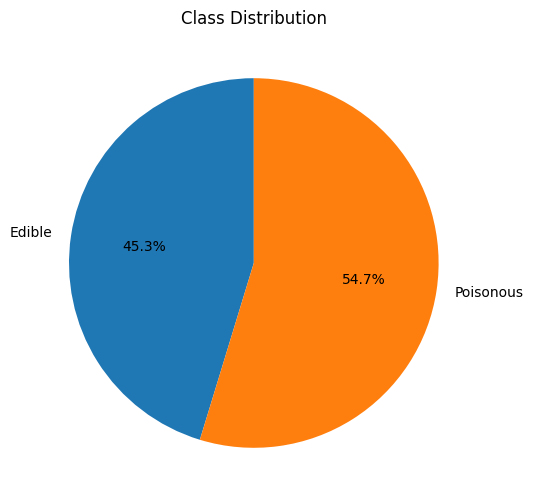

In [ ]:
class_counts = df[target_column].value_counts().sort_index()

plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=['Edible', 'Poisonous'], autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution')
plt.show()

Considering the percentage of edible and poisonous mushrooms differs by less than $10\%$, the dataset is reasonably balanced, so there is no need to perform any additional steps to alter the target value distribution.

## Training the Models

### Encoding Qualitative Data

Most machine learning algorithms and statistical models require input features to be **numerical**. Since the **UCI Mushroom dataset** is composed mostly of **qualitative features**, it is essential to convert these categories into a numerical format before model training.

There are several encoding techniques for this purpose. In this project, we use two of the most common and effective approaches: **Label Encoding**, **Ordinal Encoding** and **One-Hot Encoding**.

- **Label Encoding** assigns a unique integer to each category within a feature. This method is well-suited for models that **natively handle categorical splits** or are **insensitive to the numerical order** of values—such as Decision Trees, Random Forests, and Gradient Boosting models like XGBoost.

- **Ordinal Encoding** assigns a unique integer to each category within a feature, representing them as ordered numerical values which is suitable when the categories have an inherent rank or order. It's also commonly used with models like tree-based algorithms or Naive Bayes (e.g., CategoricalNB), which can handle categorical variables as discrete inputs without assuming a linear relationship between the encoded values.

- **One-Hot Encoding** transforms each category into a separate binary feature, assigning a `1` to the matching category and `0` to the others. This technique is especially useful for models that are **sensitive to feature magnitudes or distances**, such as Logistic Regression and K-Nearest Neighbors (KNN), ensuring that no unintended ordinal relationships are inferred between categories.

Because different models benefit from different encoding schemes, we prepare **two versions of the dataset**—one with label encoding and another with one-hot encoding. This ensures **compatibility** with a range of algorithms and allows us to evaluate each model under optimal conditions. We also sampled 100,000 rows from the original dataset to reduce computational overhead and speed up the model evaluation process.


In [ ]:
label_encoder = LabelEncoder()
ordinal_encoder = OrdinalEncoder()

# apply Label Encoding to all qualitative data
df_label_encoded = df.copy()
for column in df_label_encoded[qualitative_columns]:
    df_label_encoded[column] = label_encoder.fit_transform(df_label_encoded[column])

# apply Ordinal Encoding to all qualitative data
df_ordinal_encoded = df.copy()
df_ordinal_encoded[qualitative_columns] = ordinal_encoder.fit_transform(df_ordinal_encoded[qualitative_columns])

# apply One-Hot Encoding to all qualitative data
df_one_hot_encoded = pd.get_dummies(df, columns=qualitative_columns, drop_first=False)

# reduce the dataset to 100.000 rows
df_label_encoded = df_label_encoded.sample(n=100_000, random_state=42).reset_index(drop=True)
df_ordinal_encoded = df_ordinal_encoded.sample(n=100_000, random_state=42).reset_index(drop=True)
df_one_hot_encoded = df_one_hot_encoded.sample(n=100_000, random_state=42).reset_index(drop=True)

### Model Assessment

To thoroughly assess each model's performance, we will use both **learning curves** and **confusion matrices**. 
The learning curve helps us understand how well a model learns from data over time, revealing potential issues like underfitting (the model is too simple to capture patterns in the data) or overfitting (the model is too complex and captures noise as if it were signal). 
The confusion matrix provides detailed insight into the model's classification behavior, highlighting how predictions are distributed across actual classes. 

In addition to these visual tools, we will evaluate each model using the following key metrics: **Accuracy**, **Precision**, **Recall**, **F1-score**, and **Fit Time (in seconds)**, which offer a comprehensive view of model effectiveness, balancing correctness, sensitivity, and efficiency, respectively.


In [ ]:
def plot_confusion_matrix(model, X, y, test_size=0.2, random_state=42):
    model_name = type(model).__name__

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Fit and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= ["Edible", "Poisonous"]).plot(cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

In [ ]:
def plot_learning_curve(model, X, y, cv=3, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)):
    model_name = type(model).__name__
    
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
    plt.plot(train_sizes, val_scores_mean, 'o-', label='Cross-validation score')
    plt.title(f"{model_name} Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(scoring.capitalize())
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [ ]:
# variable to gather all scores
results = {}

def evaluate_model(model, dataset, results, cv=3):
    '''
    Evaluates a list of models using cross-validation and updates the 'results' dictionary
    with the mean scores for each model.
    '''

    model_name = type(model).__name__
    
    # define the scoring metrics
    scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

    # seperate the dataset into features (X) and target (y)

    y = dataset[target_column]
    X = dataset.drop(target_column, axis=1)
    if model_name in ["XGBClassifier"]:
        y = label_encoder.fit_transform(dataset[target_column])
        

    # perform cross-validation
    scores = cross_validate(model, X, y, scoring=scoring_metrics, cv=cv)

    # calculate the mean of each scoring metric
    metrics = {
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision_macro']),
        'Recall': np.mean(scores['test_recall_macro']),
        'F1': np.mean(scores['test_f1_macro']),
        'Train Time (s)': np.mean(scores['fit_time']),
        'Test Time (s)': np.mean(scores['score_time']),
    }

    results[model_name] = metrics
    display(pd.DataFrame({model_name: metrics}).T)
    plot_confusion_matrix(model,X,y)
    plot_learning_curve(model,X,y)

### Decision Trees

**Decision Trees** work by asking a sequence of yes/no questions about the features in a dataset to arrive at a decision. These models are quick to train and can handle both numerical and categorical inputs, which makes them quite versatile. That said, they tend to overfit if not carefully managed, especially when the tree grows too deep. As such, pruning or combining trees is often necessary.

,Accuracy,Precision,Recall,F1,Train Time (s),Test Time (s)
DecisionTreeClassifier,0.97633,0.976142,0.976097,0.976119,0.508605,0.35936


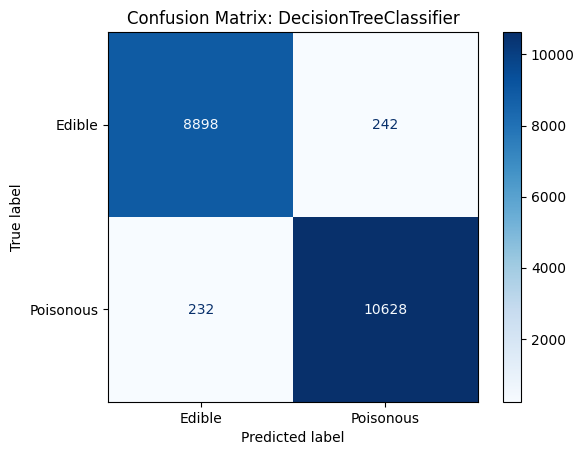

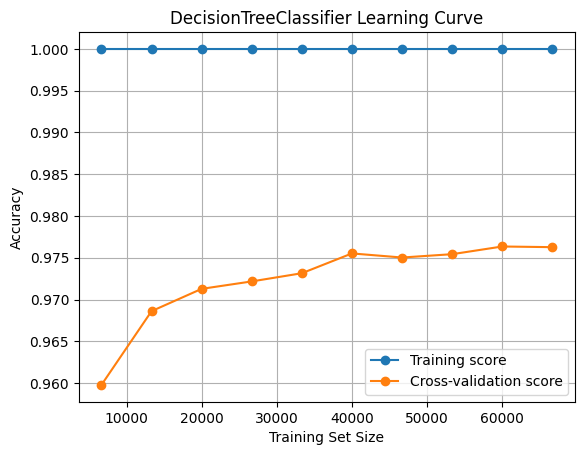

In [ ]:
evaluate_model(DecisionTreeClassifier(random_state=21), df_label_encoded, results)

### Random Forests 
**Random Forests** build on the strengths of decision trees by creating a “forest” of them and taking the average of their predictions. This approach helps to reduce overfitting and usually results in better accuracy and stability. They work well out-of-the-box, handle missing data gracefully, and are generally reliable for a wide range of classification tasks.

,Accuracy,Precision,Recall,F1,Train Time (s),Test Time (s)
RandomForestClassifier,0.99023,0.99002,0.990277,0.990146,6.341354,0.652025


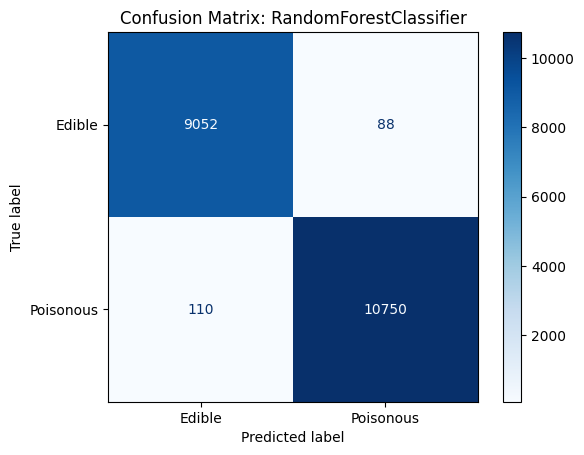

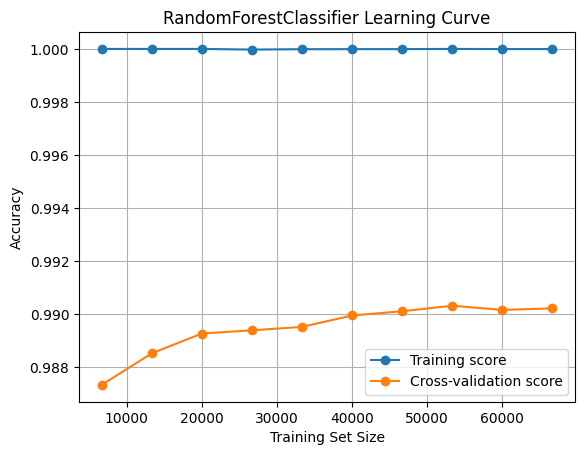

In [ ]:
evaluate_model(RandomForestClassifier(random_state=21), df_label_encoded, results)

### Categorical Naive Bayes

**Categorical Naive Bayes**, also known as CategoricalNB, is a version of the Naive Bayes algorithm tailored for datasets with several categorical features, making it appropriate for our data. It assumes that each feature contributes independently to the outcome, which isn't always true, but the simplicity of this assumption makes the model extremely fast and often surprisingly accurate.

,Accuracy,Precision,Recall,F1,Train Time (s),Test Time (s)
CategoricalNB,0.79066,0.788779,0.78927,0.78899,0.106931,0.259865


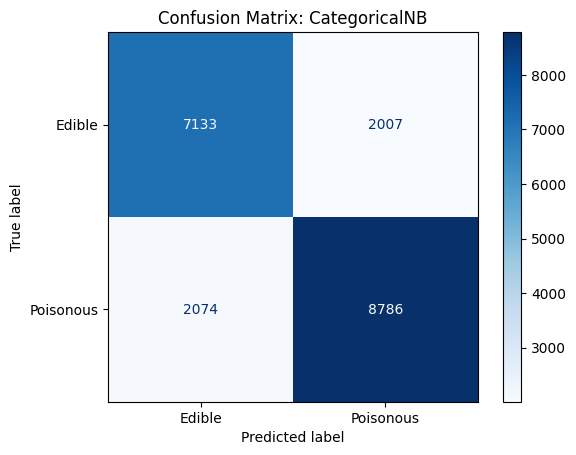

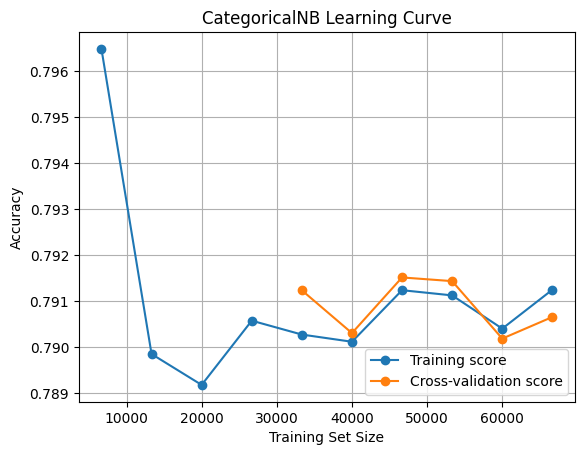

In [ ]:
evaluate_model(CategoricalNB(), df_ordinal_encoded, results)

### Logistic Regression

**Logistic Regression** is a straightforward yet surprisingly powerful algorithm for binary classification. It works by estimating the probability that a given input belongs to a certain class. It’s fast, interpretable, and often serves as a solid baseline when starting out. However, it’s best suited for problems where the relationship between features and the target is more or less linear.

,Accuracy,Precision,Recall,F1,Train Time (s),Test Time (s)
LogisticRegression,0.85655,0.855054,0.856032,0.855487,2.267809,0.321285


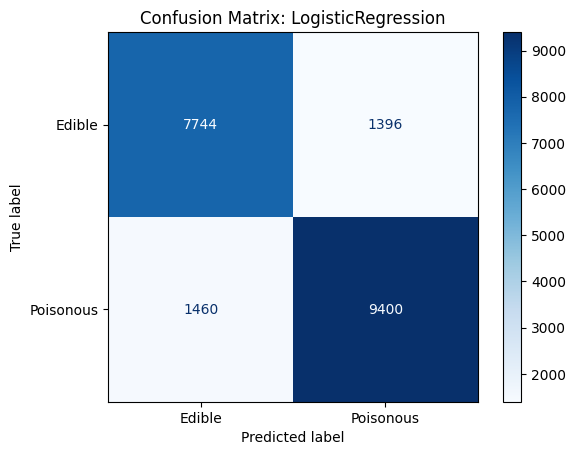

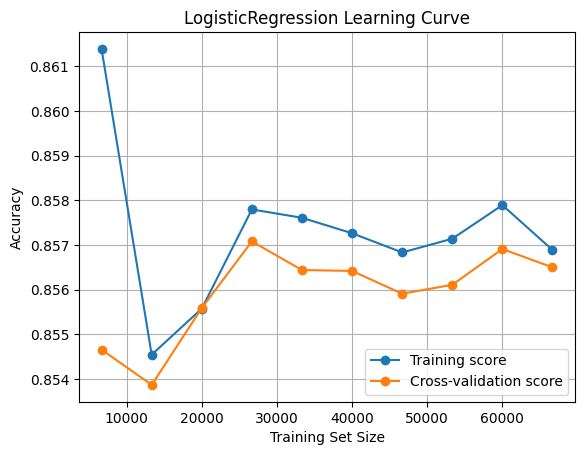

In [ ]:
evaluate_model(LogisticRegression(max_iter=1000), df_one_hot_encoded, results)

### K-Nearest Neighbors

**K-Nearest Neighbors** (KNN) works in a different particular way: instead of learning an internal model, it looks at the “closest” examples in the training data and bases its prediction on those. It’s simple and intuitive but doesn’t scale very well with large datasets or high-dimensional data. KNN also depends heavily on how distance is measured, which can be tricky with many categorical features (that's why we use a dataset that has been previously one-hot encoded).

,Accuracy,Precision,Recall,F1,Train Time (s),Test Time (s)
KNeighborsClassifier,0.99089,0.990638,0.990996,0.990813,0.107557,5.775526


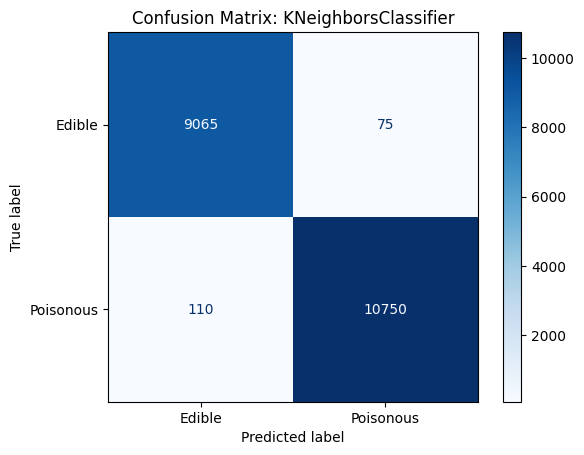

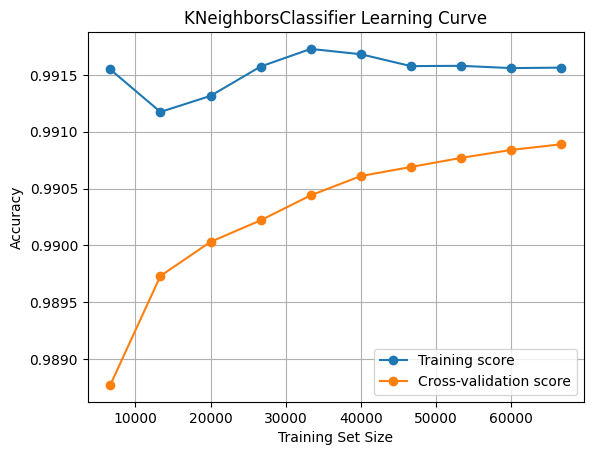

In [ ]:
evaluate_model(KNeighborsClassifier(), df_one_hot_encoded, results)

### Support Vector Machines

**Support Vector Machines** (SVM) are designed to find the best boundary that separates classes in a dataset. They’re especially powerful when the classes are distinctly separated and can even handle more complex patterns through the use of kernels. While they can be very effective, they’re not the best choice for very large or mostly categorical datasets due to their high computational cost.

,Accuracy,Precision,Recall,F1,Train Time (s),Test Time (s)
SVC,0.98667,0.986378,0.986748,0.986557,93.179814,25.833808


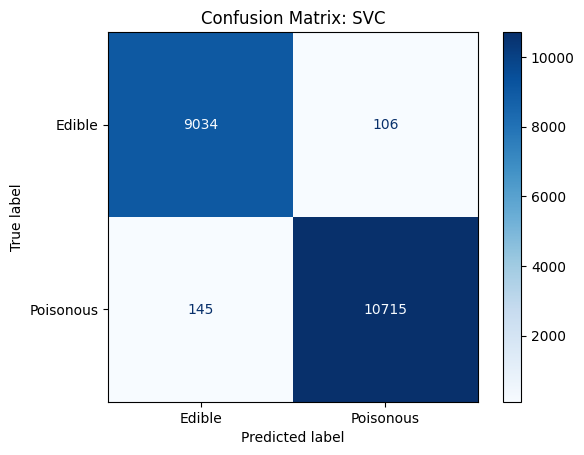

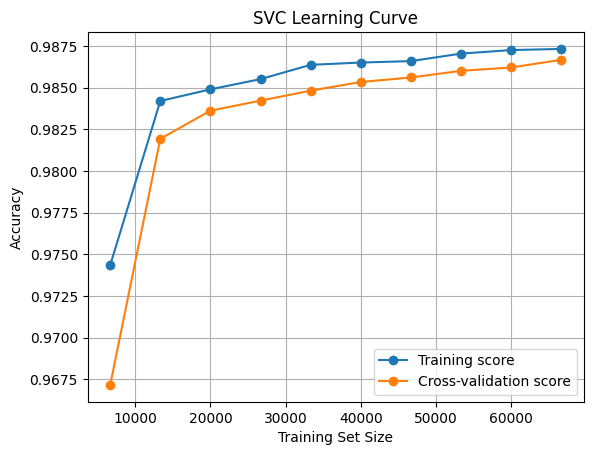

In [81]:
evaluate_model(SVC(), df_one_hot_encoded, results)

### Extreme Gradient Boosting

**Extreme Gradient Boosting**, also known as XGBoost, is a widely used machine learning algorithm known for its high performance and efficiency. It builds trees sequentially, each one improving on the last, and includes built-in methods to reduce overfitting. In many structured data problems, such as the mushroom dataset we are working with, XGBoost often delivers top-tier accuracy with reasonable training time.

,Accuracy,Precision,Recall,F1,Train Time (s),Test Time (s)
XGBClassifier,0.98954,0.989293,0.989616,0.989451,0.586997,0.063417


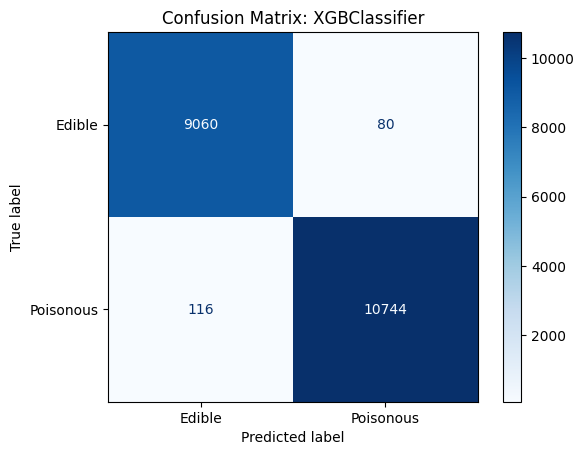

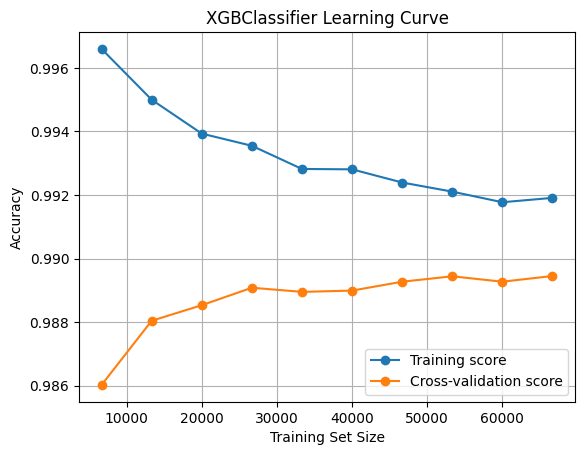

In [82]:
evaluate_model(XGBClassifier(), df_one_hot_encoded, results)

## Conclusion

### Results and Analysis

In [83]:
display(pd.DataFrame(results).T)

,Accuracy,Precision,Recall,F1,Train Time (s),Test Time (s)
DecisionTreeClassifier,0.97633,0.976142,0.976097,0.976119,0.429362,0.299980
RandomForestClassifier,0.99023,0.990020,0.990277,0.990146,5.814453,0.621719
CategoricalNB,0.79066,0.788779,0.789270,0.788990,0.119030,0.274808
LogisticRegression,0.85655,0.855054,0.856032,0.855487,2.335927,0.337456
KNeighborsClassifier,0.99089,0.990638,0.990996,0.990813,0.125690,7.442594
SVC,0.98667,0.986378,0.986748,0.986557,93.179814,25.833808
XGBClassifier,0.98954,0.989293,0.989616,0.989451,0.586997,0.063417


After testing several classifiers on the mushroom dataset, both the **XGBClassifier** and **RandomForestClassifier** came out on top. They achieved high metric scores (over 98.9%) and made very few mistakes based on their confusion matrices. Their learning curves also showed that they generalize well, with training and validation scores that stayed close together, which means there’s little sign of overfitting.

The **KNeighborsClassifier** also performed quite well. However, it requires more memory and takes longer during prediction, which makes it less practical, especially if speed or resource efficiency is important.

As for the **DecisionTreeClassifier**, it hit a perfect training score, but its validation score was noticeably lower, which is a red flag for overfitting.

The **SVC** model also achieved a good metric score, but its long training time made it less attractive for larger datasets or quicker iterations.

On the other hand, **LogisticRegression** and **CategoricalNB** didn’t perform very well in any of the tests.

All things considered, **XGBClassifier** and **RandomForestClassifier** are the strongest options here, but if we also factor in training speed, **XGBClassifier** distinguishes itself with a significantly shorter training time (0.58 seconds) compared to the **RandomForestClassifier** (6.34 seconds).

### Future Works

In order to improve the current work and achieve better model performance, future efforts could include:

- **Using a dedicated validation set:** Instead of relying only on cross-validation, splitting the data into separate training and validation sets could give clearer feedback on model generalization.

- **Hyperparameter optimization:** Leveraging methods like Bayesian optimization may lead to more accurate and reliable models by fine-tuning key parameters.

- **Droping columns with excessive missing values:** Removing columns that contain a high proportion of missing data can help reduce noise and potentially enhance model performance by focusing on more reliable features.